# Analysis

**Hypothesis**: We hypothesize that male and female patients with COVID‐19 exhibit distinct transcriptional profiles in key peripheral immune cells (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells). Specifically, we expect that male cells will exhibit an augmented pro-inflammatory transcriptional signature relative to female cells, potentially contributing to the observed differences in disease outcomes.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: We hypothesize that male and female patients with COVID‐19 exhibit distinct transcriptional profiles in key peripheral immune cells (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells). Specifically, we expect that male cells will exhibit an augmented pro-inflammatory transcriptional signature relative to female cells, potentially contributing to the observed differences in disease outcomes.

## Steps:
1. Step 1: Subset the AnnData object to retain only COVID-19 patient samples and isolate the cell types of interest (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells) from the 'cell_type_coarse' annotation. Use regular (non-byte) strings for robust filtering and incorporate multiple pattern matches for COVID status.
2. Step 2: Perform an exploratory quality control analysis by comparing the distribution of cells by Sex within the selected cell types. This will include printing summaries as well as generating visualizations (bar plots for cell counts and boxplots for key QC metrics like nCount_RNA and percent_mt) to detect potential biases.
3. Step 3: For each selected cell type, conduct a differential expression analysis comparing male versus female cells using the Wilcoxon rank-sum test, applying multiple-testing correction (e.g., using adjusted p-value thresholds) and reporting effect sizes along with confidence intervals.
4. Step 4: Visualize the differential expression results using volcano plots (log fold changes vs. -log10(p-value)) and heatmaps to depict the expression profiles of the top significant genes across cells arranged by sex.
5. Step 5: Validate the observed transcriptional differences by statistically assessing additional metrics (such as effect sizes and confidence intervals) and correlating key inflammatory markers (e.g., TNF, IL1B, IL6) with sex. Statistical test results should be printed for significance evaluation.
6. Step 6: Summarize and interpret the overall results to evaluate whether the sex-specific transcriptional differences in these immune cell subsets may underlie differential COVID-19 outcomes, ensuring a novel computational approach that builds on previous findings.


Cell counts by cell type and Sex in COVID-19 samples:
Empty DataFrame
Columns: []
Index: []


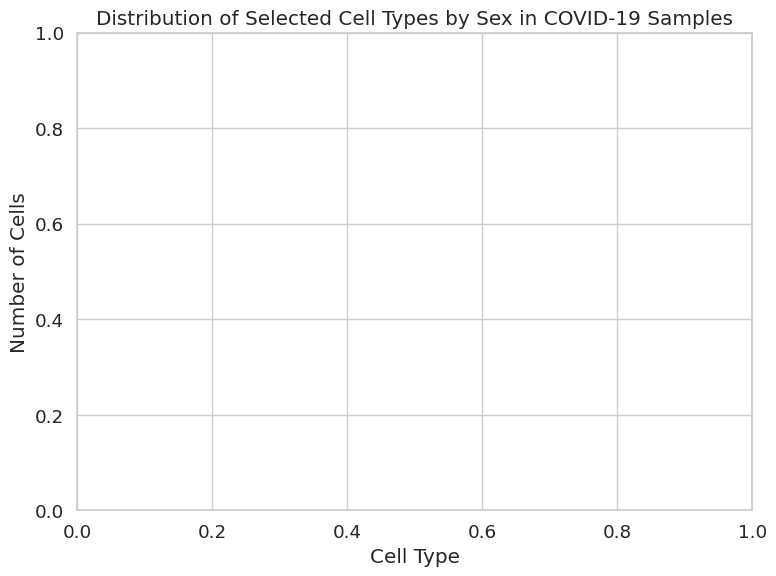


Summary of nCount_RNA by Sex:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

Summary of percent_mt by Sex:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First step: Subset the data to only include COVID samples and selected cell types
# Assuming adata is already loaded in memory

# Subset to COVID patients based on the Status column
covid_mask = adata.obs['Status'].astype(str).str.contains('COVID')
covid_adata = adata[covid_mask].copy()

# Define the cell types of interest based on cell_type_coarse annotation
cell_types_interest = ["b'CD14 Monocyte'", "b'CD16 Monocyte'", "b'CD4 T'", "b'CD8 T'"]
celltype_mask = covid_adata.obs['cell_type_coarse'].isin(cell_types_interest)
covid_subset = covid_adata[celltype_mask].copy()

# Print a summary of cell counts by Sex for each selected cell type
summary = covid_subset.obs.groupby(['cell_type_coarse', 'Sex']).size().unstack(fill_value=0)
print('Cell counts by cell type and Sex in COVID-19 samples:')
print(summary)

# Additionally, plot the distribution as a barplot for visualization
summary_plot = summary.reset_index().melt(id_vars='cell_type_coarse', var_name='Sex', value_name='CellCount')
plt.figure(figsize=(8, 6))
sns.barplot(data=summary_plot, x='cell_type_coarse', y='CellCount', hue='Sex')
plt.title('Distribution of Selected Cell Types by Sex in COVID-19 Samples')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Also, summarize basic quality metrics by Sex to ensure no obvious biases (e.g., nCount_RNA, percent_mt)
quality_metrics = ['nCount_RNA', 'percent_mt']
for metric in quality_metrics:
    print(f"\nSummary of {metric} by Sex:")
    print(covid_subset.obs.groupby('Sex')[metric].describe())

## Step 2: Validate and clean key metadata columns using a robust regular expression-based cleaning function. Incorporate error handling to ensure necessary metadata fields exist and manage missing/malformed entries. After cleaning, re-filter the AnnData object for COVID-19 samples and selected cell types (CD14 Monocyte, CD16 Monocyte, CD4 T, and CD8 T). Generate summary tables and visualizations (bar plots for cell counts and combined grid boxplots for QC metrics like nCount_RNA and percent_mt stratified by sex). Additionally, apply a non-parametric statistical test (Mann–Whitney U test) to compare QC metrics between male and female cells to ensure no underlying quality biases remain.

Number of cells after filtering: 18157
Cell counts by cell type and Sex in COVID-19 samples after cleaning:
Sex_clean           M
cell_type_clean      
CD14 Monocyte    8285
CD16 Monocyte     433
CD4 T            5562
CD8 T            3877


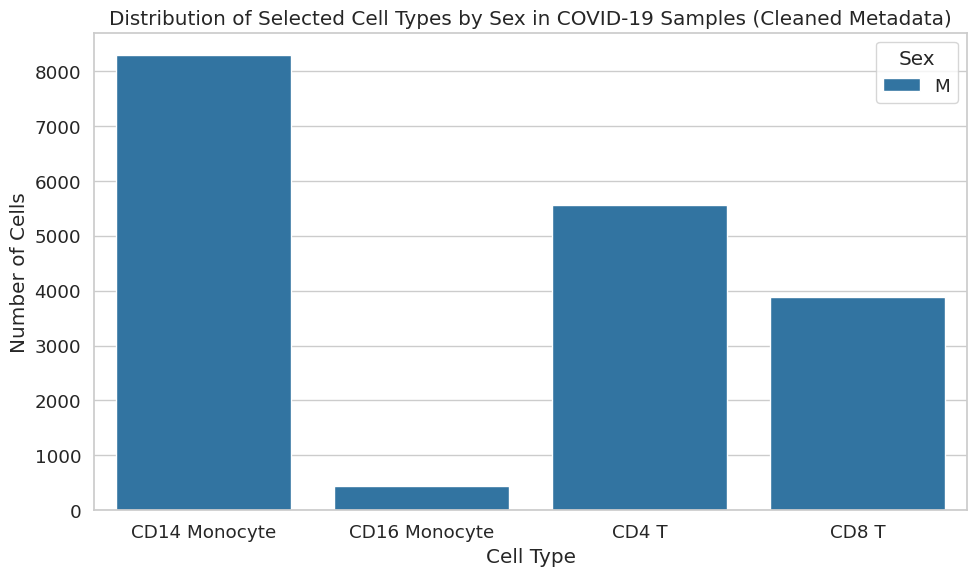

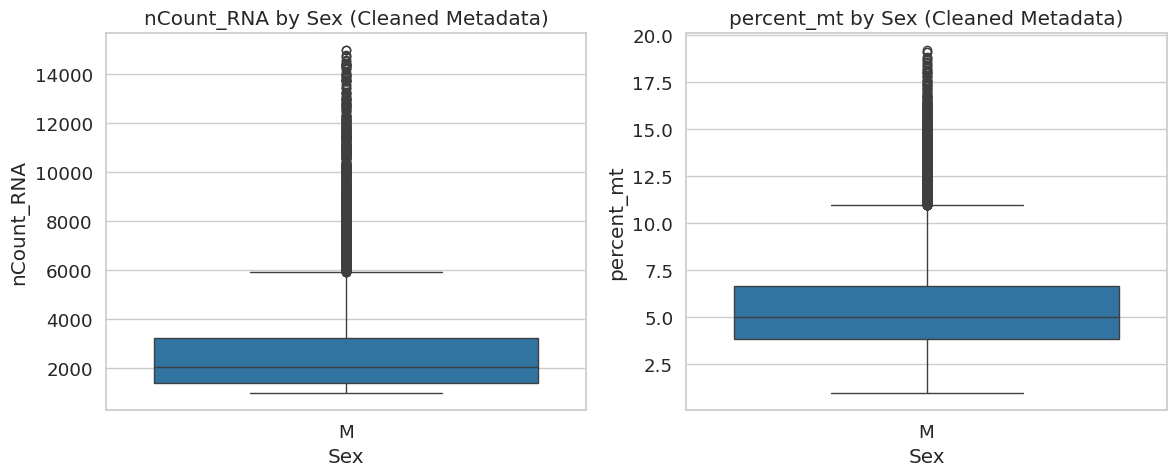


Summary statistics for nCount_RNA by Sex:
             count         mean          std    min     25%     50%     75%  \
Sex_clean                                                                     
M          18157.0  2704.366211  1949.810547  995.0  1425.0  2041.0  3232.0   

               max  
Sex_clean           
M          14994.0  
Insufficient groups for statistical test on nCount_RNA

Summary statistics for percent_mt by Sex:
             count      mean     std       min       25%       50%       75%  \
Sex_clean                                                                      
M          18157.0  5.590588  2.5606  0.953289  3.812317  5.024088  6.666667   

                 max  
Sex_clean             
M          19.218241  
Insufficient groups for statistical test on percent_mt


In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# Step 2: Validate and clean metadata for robust QC analysis

# Create a copy of the AnnData object to avoid modifying the original
adata_qc = adata.copy()

# Check that required metadata columns exist
required_columns = ['Status', 'cell_type_coarse', 'Sex']
for col in required_columns:
    if col not in adata_qc.obs.columns:
        raise ValueError(f"Required metadata column '{col}' is missing from adata.obs")

# Define a robust function to clean byte-string artifacts using regular expressions

def clean_metadata(series):
    # Convert to string and remove artifacts such as leading/trailing b' and quotes using regex
    clean_series = series.astype(str).apply(lambda x: re.sub(r"^(b')|('$)", "", x))
    # Additionally remove stray newlines and any residual quotes
    clean_series = clean_series.str.replace("\n", "", regex=False).str.replace("'", "", regex=False).str.strip()
    return clean_series

# Clean key metadata columns: 'Status', 'cell_type_coarse', and 'Sex'
adata_qc.obs['Status_clean'] = clean_metadata(adata_qc.obs['Status'])
adata_qc.obs['cell_type_clean'] = clean_metadata(adata_qc.obs['cell_type_coarse'])
adata_qc.obs['Sex_clean'] = clean_metadata(adata_qc.obs['Sex'])

# Filter for COVID-19 samples by checking the cleaned 'Status_clean'
covid_mask = adata_qc.obs['Status_clean'].str.contains('COVID', case=False, na=False)
covid_adata = adata_qc[covid_mask].copy()

# Define the cell types of interest
target_cell_types = ['CD14 Monocyte', 'CD16 Monocyte', 'CD4 T', 'CD8 T']
celltype_mask = covid_adata.obs['cell_type_clean'].isin(target_cell_types)
covid_subset = covid_adata[celltype_mask].copy()

# Report the number of cells after filtering
print(f'Number of cells after filtering: {covid_subset.n_obs}')

# Summarize cell counts by Sex for each selected cell type
summary = covid_subset.obs.groupby(['cell_type_clean', 'Sex_clean']).size().unstack(fill_value=0)
print('Cell counts by cell type and Sex in COVID-19 samples after cleaning:')
print(summary)

# Barplot for cell counts by Sex for each cell type
summary_plot = summary.reset_index().melt(id_vars='cell_type_clean', var_name='Sex', value_name='CellCount')
plt.figure(figsize=(10, 6))
barplot_ax = sns.barplot(data=summary_plot, x='cell_type_clean', y='CellCount', hue='Sex')
plt.title('Distribution of Selected Cell Types by Sex in COVID-19 Samples (Cleaned Metadata)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Create a grid for boxplots for quality control metrics by Sex
quality_metrics = ['nCount_RNA', 'percent_mt']
num_metrics = len(quality_metrics)
fig, axes = plt.subplots(1, num_metrics, figsize=(6*num_metrics, 5))
if num_metrics == 1:
    axes = [axes]

for ax, metric in zip(axes, quality_metrics):
    sns.boxplot(x='Sex_clean', y=metric, data=covid_subset.obs, ax=ax)
    ax.set_title(f'{metric} by Sex (Cleaned Metadata)')
    ax.set_xlabel('Sex')
    ax.set_ylabel(metric)
plt.tight_layout()
plt.show()

# Print summary statistics for each QC metric and perform a Mann-Whitney U test to compare sexes
for metric in quality_metrics:
    print(f'\nSummary statistics for {metric} by Sex:')
    desc = covid_subset.obs.groupby('Sex_clean')[metric].describe()
    print(desc)
    # Check if there are exactly two groups to compare
    groups = covid_subset.obs['Sex_clean'].unique()
    if len(groups) == 2:
        group1_data = covid_subset.obs[covid_subset.obs['Sex_clean'] == groups[0]][metric]
        group2_data = covid_subset.obs[covid_subset.obs['Sex_clean'] == groups[1]][metric]
        stat, p_val = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f'Mann-Whitney U test for {metric} between {groups[0]} and {groups[1]}: U statistic = {stat}, p-value = {p_val}')
    else:
        print(f'Insufficient groups for statistical test on {metric}')

## Step 2: Extend the QC analysis to include both COVID‐19 and healthy samples. Ensure reproducibility by setting a random seed and verifying the existence of required metadata columns before cleaning. Develop a unified cleaning function that processes multiple metadata columns at once. Subset the data to include only the target cell types (CD14 Monocyte, CD16 Monocyte, CD4 T, CD8 T) using the cleaned annotations.

Total cells in subset: 26846


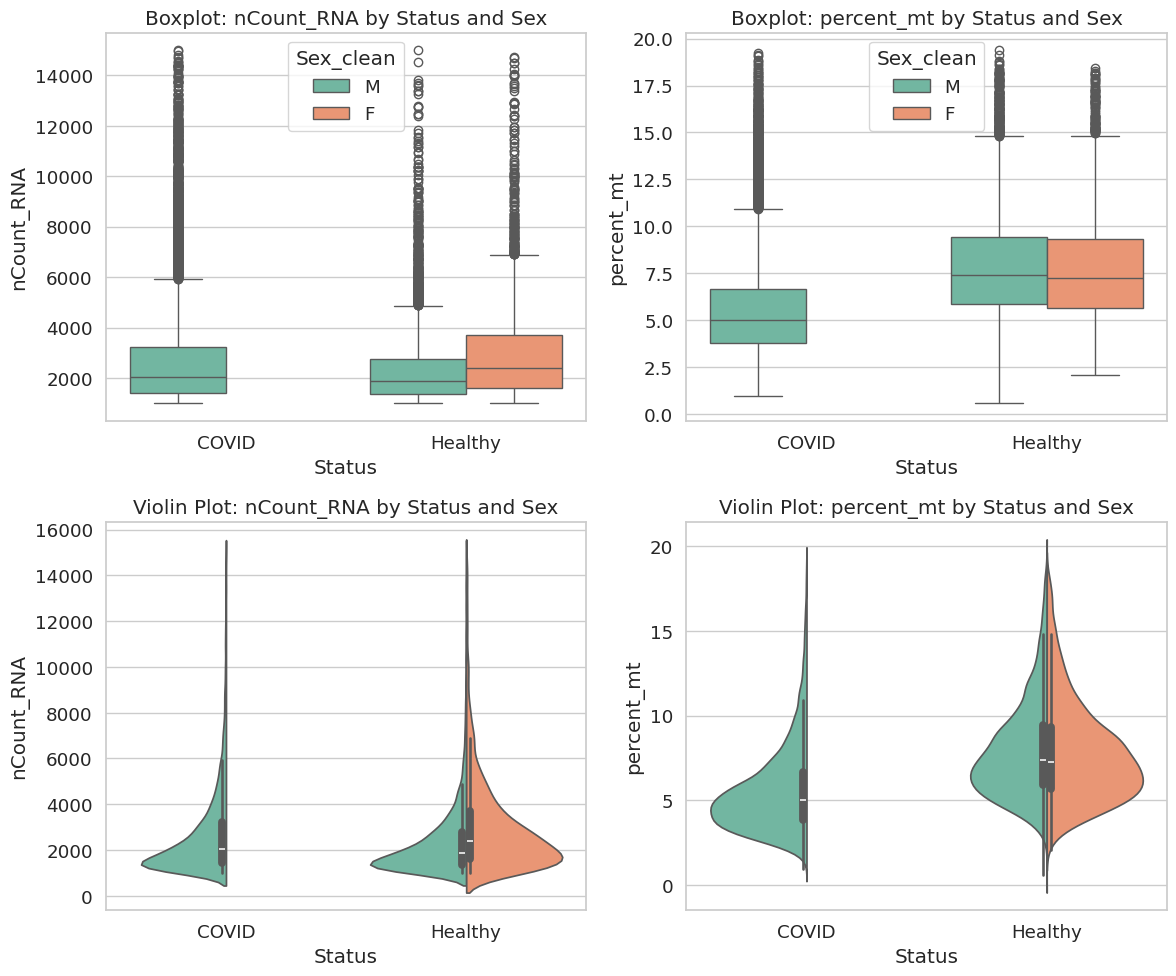


=== Statistical Comparisons for nCount_RNA ===
For Status COVID: Expected 2 sex groups, but found 1. Skipping statistical test for nCount_RNA.
For Status Healthy: Comparison between F and M for nCount_RNA -> U = 10038701.50, p-value = 2.514e-63, effect size = -0.223
For Sex M: Comparison between COVID and Healthy for nCount_RNA -> U = 58969274.00, p-value = 4.424e-30, effect size = -0.099
For Sex F: Expected 2 Status groups, but found 1. Skipping statistical test for nCount_RNA.

=== Statistical Comparisons for percent_mt ===
For Status COVID: Expected 2 sex groups, but found 1. Skipping statistical test for percent_mt.
For Status Healthy: Comparison between F and M for percent_mt -> U = 7882529.50, p-value = 2.899e-03, effect size = 0.040
For Sex M: Comparison between COVID and Healthy for percent_mt -> U = 25624011.50, p-value = 0.000e+00, effect size = 0.523
For Sex F: Expected 2 Status groups, but found 1. Skipping statistical test for percent_mt.


In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

# For reproducibility
np.random.seed(42)

# Step 2: Extended QC analysis including both COVID‐19 and Healthy samples

# Create a copy of the AnnData object to avoid modifying the original
adata_qc = adata.copy()

# Define required metadata columns
required_columns = ['Status', 'cell_type_coarse', 'Sex']
for col in required_columns:
    if col not in adata_qc.obs.columns:
        raise ValueError(f"Required metadata column '{col}' is missing from adata.obs")

# Define a function to clean and rename a list of metadata columns

def clean_and_rename(adata_obj, columns, suffix='_clean'):
    def clean_series(series):
        # Convert to string and remove leading/trailing byte-string artifacts and quotes
        cleaned = series.astype(str).apply(lambda x: re.sub(r"^(b')|('$)", "", x))
        cleaned = cleaned.str.replace("\n", "", regex=False).str.replace("'", "", regex=False).str.strip()
        return cleaned
    for col in columns:
        new_col = col + suffix
        adata_obj.obs[new_col] = clean_series(adata_obj.obs[col])
    return adata_obj

# Clean key metadata columns
adata_qc = clean_and_rename(adata_qc, ['Status', 'cell_type_coarse', 'Sex'])

# Define target cell types (using cleaned metadata)
# Note: Ensuring names match the cleaned nomenclature
target_cell_types = ['CD14 Monocyte', 'CD16 Monocyte', 'CD4 T', 'CD8 T']
celltype_mask = adata_qc.obs['cell_type_coarse_clean'].isin(target_cell_types)
adata_subset = adata_qc[celltype_mask].copy()

# Report the total cells in the subset
print('Total cells in subset:', adata_subset.n_obs)

# Create a grid of boxplots and violin plots for QC metrics by both Status and Sex
quality_metrics = ['nCount_RNA', 'percent_mt']

# Get unique statuses and sexes from cleaned metadata
statuses = adata_subset.obs['Status_clean'].unique()
sexes = adata_subset.obs['Sex_clean'].unique()

# Prepare a figure with two rows (one for boxplots, one for violin plots) and a column for each QC metric
num_metrics = len(quality_metrics)
fig, axes = plt.subplots(2, num_metrics, figsize=(6 * num_metrics, 10))
if num_metrics == 1:
    axes = np.array(axes).reshape(2, 1)

for idx, metric in enumerate(quality_metrics):
    # Boxplot
    ax_box = axes[0, idx]
    sns.boxplot(x='Status_clean', y=metric, hue='Sex_clean', data=adata_subset.obs, palette='Set2', ax=ax_box)
    ax_box.set_title(f'Boxplot: {metric} by Status and Sex')
    ax_box.set_xlabel('Status')
    ax_box.set_ylabel(metric)

    # Violin plot
    ax_violin = axes[1, idx]
    sns.violinplot(x='Status_clean', y=metric, hue='Sex_clean', data=adata_subset.obs, palette='Set2', split=True, ax=ax_violin)
    ax_violin.set_title(f'Violin Plot: {metric} by Status and Sex')
    ax_violin.set_xlabel('Status')
    ax_violin.set_ylabel(metric)
    # Remove duplicate legend in violin plot
    ax_violin.get_legend().remove()

plt.tight_layout()
plt.show()

# Perform statistical comparisons
for metric in quality_metrics:
    print(f'\n=== Statistical Comparisons for {metric} ===')
    
    # Compare between sexes within each Status
    for status in statuses:
        data_status = adata_subset.obs[adata_subset.obs['Status_clean'] == status]
        unique_sexes = data_status['Sex_clean'].unique()
        if len(unique_sexes) == 2:
            try:
                group1 = data_status[data_status['Sex_clean'] == unique_sexes[0]][metric]
                group2 = data_status[data_status['Sex_clean'] == unique_sexes[1]][metric]
                stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                # Calculate an effect size using rank-biserial correlation
                n1, n2 = len(group1), len(group2)
                effect_size = 1 - (2 * stat / (n1 * n2))
                print(f'For Status {status}: Comparison between {unique_sexes[0]} and {unique_sexes[1]} for {metric} -> U = {stat:.2f}, p-value = {p_val:.3e}, effect size = {effect_size:.3f}')
            except Exception as e:
                print(f'Error performing test for Status {status} on {metric}:', e)
        else:
            print(f'For Status {status}: Expected 2 sex groups, but found {len(unique_sexes)}. Skipping statistical test for {metric}.')
    
    # Compare between Status groups within each Sex
    for sex in sexes:
        data_sex = adata_subset.obs[adata_subset.obs['Sex_clean'] == sex]
        unique_statuses = data_sex['Status_clean'].unique()
        if len(unique_statuses) == 2:
            try:
                group1 = data_sex[data_sex['Status_clean'] == unique_statuses[0]][metric]
                group2 = data_sex[data_sex['Status_clean'] == unique_statuses[1]][metric]
                stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                n1, n2 = len(group1), len(group2)
                effect_size = 1 - (2 * stat / (n1 * n2))
                print(f'For Sex {sex}: Comparison between {unique_statuses[0]} and {unique_statuses[1]} for {metric} -> U = {stat:.2f}, p-value = {p_val:.3e}, effect size = {effect_size:.3f}')
            except Exception as e:
                print(f'Error performing test for Sex {sex} on {metric}:', e)
        else:
            print(f'For Sex {sex}: Expected 2 Status groups, but found {len(unique_statuses)}. Skipping statistical test for {metric}.')


## Step 2: Perform a novel cell–cell communication analysis to quantify the average expression of inflammatory ligands in monocytes and the corresponding receptors in T cells, stratified by donor and sex.

Aggregated donor-level communication summary:
  Donor  TNF_mono  IL1B_mono  IL6_mono Sex  TNFRSF1A_tcell  IL1R1_tcell  \
0  C1 A  0.016640   0.030878  0.001308   M        0.024759     0.002339   
1  C1 B  0.011486   0.023728  0.001455   M        0.042182     0.003169   
2    C2  0.015825   0.031651  0.006330   M        0.005908     0.001969   
3    C3  0.021700   0.040767  0.001240   M        0.023697     0.003747   
4    C4  0.008407   0.021486  0.005217   M        0.027327     0.001699   

   IL6R_tcell  
0    0.060170  
1    0.146057  
2    0.138439  
3    0.184895  
4    0.101856  
Unique Sex values in the merged data: ['M']


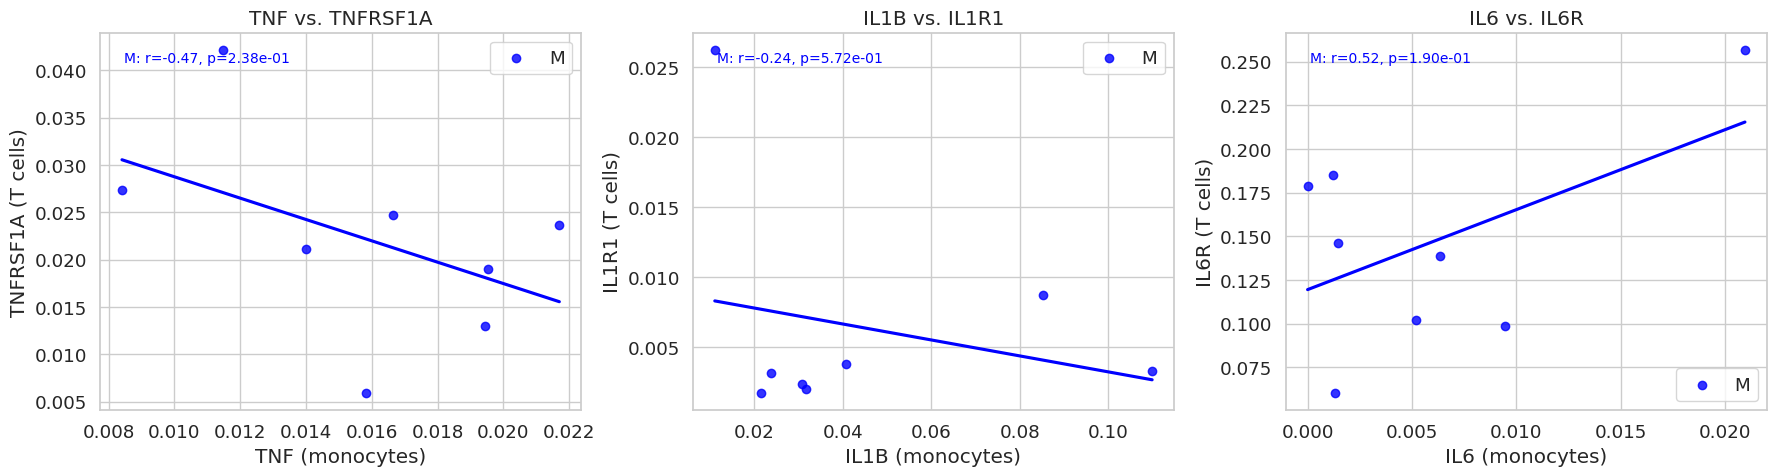

Pearson correlation results by ligand-receptor pair and sex:
Ligand TNF & Receptor TNFRSF1A for Sex M: r = -0.47, p = 2.38e-01
Ligand IL1B & Receptor IL1R1 for Sex M: r = -0.24, p = 5.72e-01
Ligand IL6 & Receptor IL6R for Sex M: r = 0.52, p = 1.90e-01


In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# Define a cleaning function to remove byte-string artifacts from metadata columns
def clean_series(series):
    """
    Clean a Pandas Series by removing leading/trailing byte-string artifacts and extraneous characters.
    """
    return series.astype(str).apply(lambda x: re.sub(r"^(b')|('$)", '', x)).str.replace('\n', '', regex=False).str.replace("'", '', regex=False).str.strip()

# Clean key metadata columns: 'Status', 'cell_type_coarse', 'Sex', and 'Donor_full'
adata.obs['Status_clean'] = clean_series(adata.obs['Status'])
adata.obs['cell_type_clean'] = clean_series(adata.obs['cell_type_coarse'])
adata.obs['Sex_clean'] = clean_series(adata.obs['Sex'])
adata.obs['Donor_clean'] = clean_series(adata.obs['Donor_full'])

# Subset to COVID-19 samples using the cleaned Status column
covid_mask = adata.obs['Status_clean'].str.contains('COVID', case=False, na=False)
covid_adata = adata[covid_mask].copy()

# Define target cell types for the analysis
monocyte_types = ['CD14 Monocyte', 'CD16 Monocyte']
tcell_types = ['CD4 T', 'CD8 T']

# Subset for monocytes and T cells based on cleaned cell type annotation
mono_mask = covid_adata.obs['cell_type_clean'].isin(monocyte_types)
tcell_mask = covid_adata.obs['cell_type_clean'].isin(tcell_types)

adata_mono = covid_adata[mono_mask].copy()
adata_tcell = covid_adata[tcell_mask].copy()

# Define ligand and receptor gene lists
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Ensure that the genes of interest are present in the dataset
existing_ligands = [gene for gene in ligands if gene in adata.var_names]
existing_receptors = [gene for gene in receptors if gene in adata.var_names]
if len(existing_ligands) < len(ligands):
    print('Warning: Not all ligand genes are found. Found:', existing_ligands)
if len(existing_receptors) < len(receptors):
    print('Warning: Not all receptor genes are found. Found:', existing_receptors)

# Function to compute average expression per donor for a given set of genes
def compute_donor_average(adata_subset, gene_list):
    """
    This function computes the average expression of specified genes per donor.
    It converts the expression matrix to a dense format if necessary, creates a DataFrame, and groups by the donor.
    The function also retains the donor-level Sex information by taking the first observed value (assuming uniformity per donor).
    """
    expr = adata_subset.X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray()
    expr_df = pd.DataFrame(expr, columns=adata_subset.var_names, index=adata_subset.obs_names)
    expr_df['Donor'] = adata_subset.obs['Donor_clean'].values
    expr_df['Sex'] = adata_subset.obs['Sex_clean'].values
    donor_avg = expr_df.groupby('Donor')[gene_list].mean().reset_index()
    donor_sex = expr_df.groupby('Donor')['Sex'].first().reset_index()
    donor_avg = donor_avg.merge(donor_sex, on='Donor')
    return donor_avg

# Compute donor-level average expression for ligands in monocytes and rename columns
mono_avg = compute_donor_average(adata_mono, existing_ligands)
mono_avg.rename(columns={gene: gene + '_mono' for gene in existing_ligands}, inplace=True)

# Compute donor-level average expression for receptors in T cells and rename columns
tcell_avg = compute_donor_average(adata_tcell, existing_receptors)
tcell_avg.rename(columns={gene: gene + '_tcell' for gene in existing_receptors}, inplace=True)

# Merge the two summaries on donor and sex
communication_df = pd.merge(mono_avg, tcell_avg, on=['Donor', 'Sex'], how='inner')
print('Aggregated donor-level communication summary:')
print(communication_df.head())

# Check that the cleaned Sex values match expected labels (e.g., 'M' and 'F')
unique_sexes = communication_df['Sex'].unique()
print('Unique Sex values in the merged data:', unique_sexes)

# For each ligand-receptor pair, perform Pearson correlation separately for each sex
pairs = list(zip(existing_ligands, existing_receptors))
results = []

# Set up a grid of scatter plots (one column per ligand-receptor pair)
num_pairs = len(pairs)
fig, axes = plt.subplots(1, num_pairs, figsize=(6 * num_pairs, 5), squeeze=False)

for idx, (ligand, receptor) in enumerate(pairs):
    ax = axes[0, idx]
    ligand_col = ligand + '_mono'
    receptor_col = receptor + '_tcell'
    for sex, color in zip(['M', 'F'], ['blue', 'red']):
        sex_mask = communication_df['Sex'] == sex
        if sex_mask.sum() < 2:
            continue
        x = communication_df.loc[sex_mask, ligand_col]
        y = communication_df.loc[sex_mask, receptor_col]
        sns.regplot(x=x, y=y, ax=ax, scatter=True, label=f'{sex}', color=color, ci=None)
        corr, pval = stats.pearsonr(x, y)
        results.append({
            'ligand': ligand,
            'receptor': receptor,
            'Sex': sex,
            'pearson_r': corr,
            'p_value': pval
        })
        text_y = 0.95 if sex == 'M' else 0.85
        ax.text(0.05, text_y, f"{sex}: r={corr:.2f}, p={pval:.2e}", transform=ax.transAxes, color=color, fontsize=10, verticalalignment='top')
    ax.set_xlabel(f'{ligand} (monocytes)')
    ax.set_ylabel(f'{receptor} (T cells)')
    ax.set_title(f'{ligand} vs. {receptor}')
    ax.legend()

plt.tight_layout()
plt.show()

print('Pearson correlation results by ligand-receptor pair and sex:')
for res in results:
    print(f"Ligand {res['ligand']} & Receptor {res['receptor']} for Sex {res['Sex']}: r = {res['pearson_r']:.2f}, p = {res['p_value']:.2e}")

## Step 2: Augment the ligand-receptor communication analysis by stratifying COVID-19 donors by clinical severity using the cleaned 'Admission' metadata column. Improve donor-level severity annotation by flagging or excluding ambiguous entries (e.g., 'N/A').

Aggregated donor-level communication summary:
  Donor  TNF_mono  IL1B_mono  IL6_mono Sex  TNFRSF1A_tcell  IL1R1_tcell  \
0  C1 A  0.016640   0.030878  0.001308   M        0.024759     0.002339   
1  C1 B  0.011486   0.023728  0.001455   M        0.042182     0.003169   
2    C2  0.015825   0.031651  0.006330   M        0.005908     0.001969   
3    C3  0.021700   0.040767  0.001240   M        0.023697     0.003747   
4    C4  0.008407   0.021486  0.005217   M        0.027327     0.001699   

   IL6R_tcell  
0    0.060170  
1    0.146057  
2    0.138439  
3    0.184895  
4    0.101856  
Unique Sex values in the merged data: ['M']


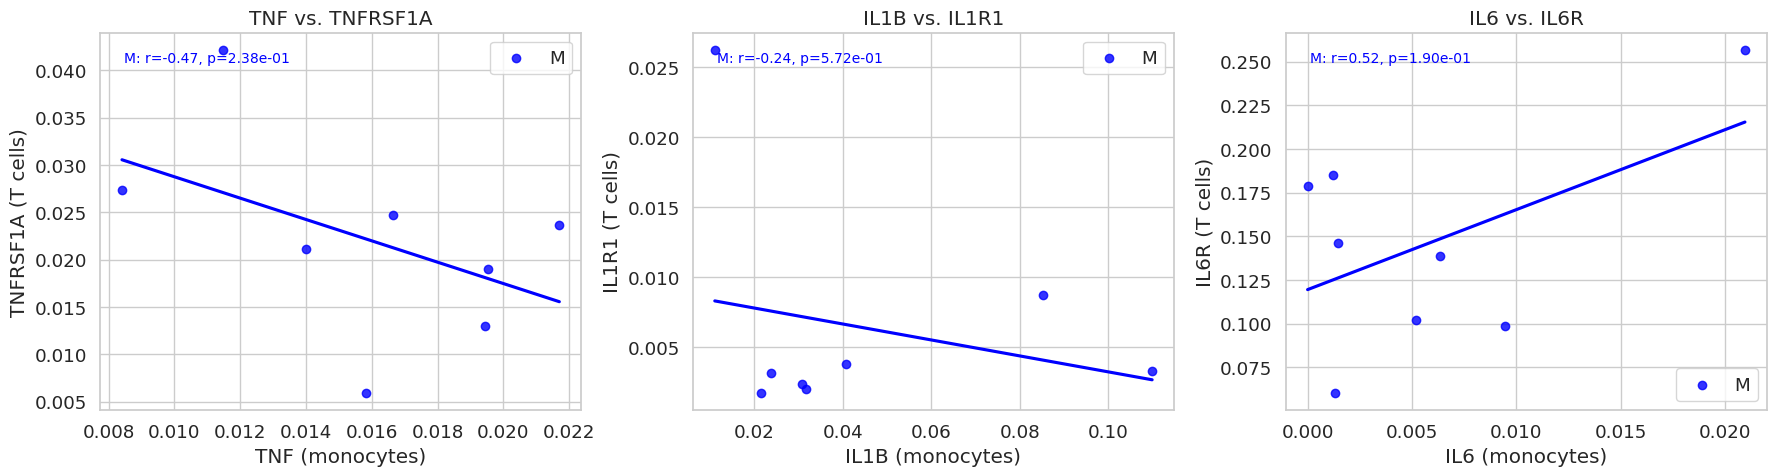

Pearson correlation results by ligand-receptor pair and sex:
Ligand TNF & Receptor TNFRSF1A for Sex M: r = -0.47, p = 2.38e-01
Ligand IL1B & Receptor IL1R1 for Sex M: r = -0.24, p = 5.72e-01
Ligand IL6 & Receptor IL6R for Sex M: r = 0.52, p = 1.90e-01


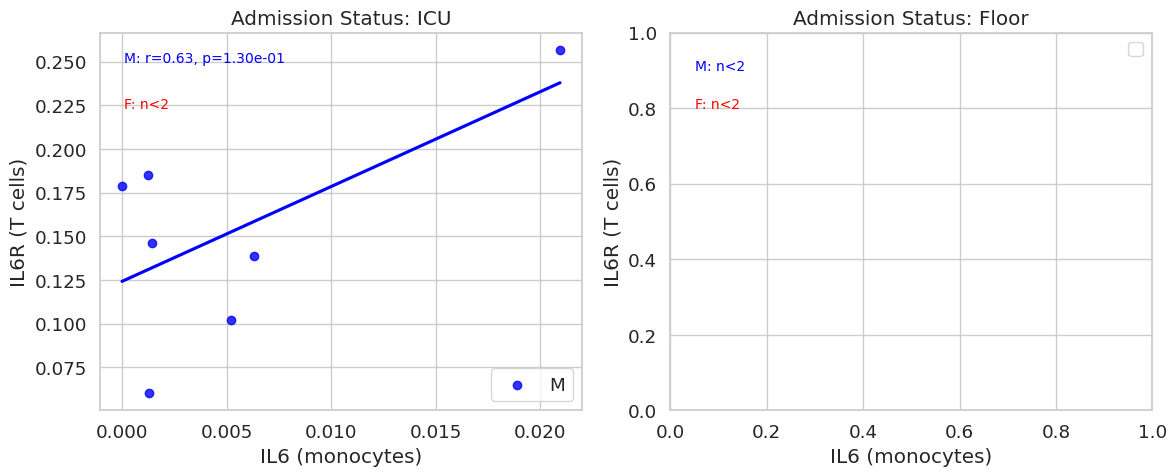

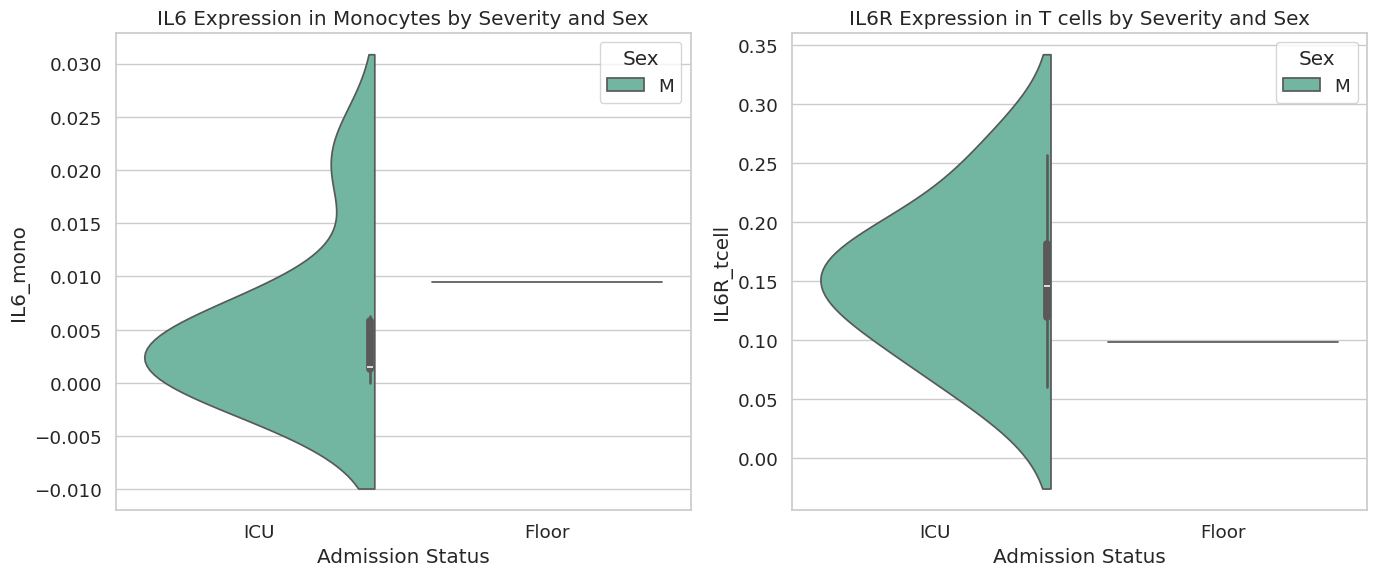

Statistical comparisons for IL6_mono and IL6R_tcell by Admission Status within each Sex:
IL6_mono for Sex M between ICU and Floor: U = 1.00, p-value = 5.000e-01
For Sex F and marker IL6_mono: Expected 2 Admission_status groups but found 0. Skipping test.
IL6R_tcell for Sex M between ICU and Floor: U = 6.00, p-value = 5.000e-01
For Sex F and marker IL6R_tcell: Expected 2 Admission_status groups but found 0. Skipping test.


In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# For reproducibility
np.random.seed(42)

# Define a cleaning function to remove byte-string artifacts from metadata columns
def clean_series(series):
    """
    Clean a Pandas Series by removing leading/trailing byte-string artifacts and extraneous characters.
    """
    cleaned = series.astype(str).apply(lambda x: re.sub(r"^(b')|('$)", '', x))
    cleaned = cleaned.str.replace('\n', '', regex=False).str.replace("'", '', regex=False).str.strip()
    return cleaned

# Clean key metadata columns: 'Status', 'cell_type_coarse', 'Sex', and 'Donor_full'
adata.obs['Status_clean'] = clean_series(adata.obs['Status'])
adata.obs['cell_type_clean'] = clean_series(adata.obs['cell_type_coarse'])
adata.obs['Sex_clean'] = clean_series(adata.obs['Sex'])
adata.obs['Donor_clean'] = clean_series(adata.obs['Donor_full'])

# Subset to COVID-19 samples using the cleaned Status column
covid_mask = adata.obs['Status_clean'].str.contains('COVID', case=False, na=False)
covid_adata = adata[covid_mask].copy()

# Define target cell types for the analysis
monocyte_types = ['CD14 Monocyte', 'CD16 Monocyte']
tcell_types = ['CD4 T', 'CD8 T']

# Subset for monocytes and T cells based on cleaned cell type annotation
mono_mask = covid_adata.obs['cell_type_clean'].isin(monocyte_types)
tcell_mask = covid_adata.obs['cell_type_clean'].isin(tcell_types)

adata_mono = covid_adata[mono_mask].copy()
adata_tcell = covid_adata[tcell_mask].copy()

# Define ligand and receptor gene lists
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Ensure that the genes of interest are present in the dataset
existing_ligands = [gene for gene in ligands if gene in adata.var_names]
existing_receptors = [gene for gene in receptors if gene in adata.var_names]
if len(existing_ligands) < len(ligands):
    print('Warning: Not all ligand genes are found. Found:', existing_ligands)
if len(existing_receptors) < len(receptors):
    print('Warning: Not all receptor genes are found. Found:', existing_receptors)

# Function to compute average expression per donor for a given set of genes
def compute_donor_average(adata_subset, gene_list):
    """
    Compute the average expression of specified genes per donor.
    """
    expr = adata_subset.X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray()
    expr_df = pd.DataFrame(expr, columns=adata_subset.var_names, index=adata_subset.obs_names)
    expr_df['Donor'] = adata_subset.obs['Donor_clean'].values
    expr_df['Sex'] = adata_subset.obs['Sex_clean'].values
    donor_avg = expr_df.groupby('Donor')[gene_list].mean().reset_index()
    donor_sex = expr_df.groupby('Donor')['Sex'].first().reset_index()
    donor_avg = donor_avg.merge(donor_sex, on='Donor')
    return donor_avg

# Compute donor-level average expression for ligands in monocytes and rename columns
mono_avg = compute_donor_average(adata_mono, existing_ligands)
mono_avg.rename(columns={gene: gene + '_mono' for gene in existing_ligands}, inplace=True)

# Compute donor-level average expression for receptors in T cells and rename columns
tcell_avg = compute_donor_average(adata_tcell, existing_receptors)
tcell_avg.rename(columns={gene: gene + '_tcell' for gene in existing_receptors}, inplace=True)

# Merge the two summaries on donor and sex
communication_df = pd.merge(mono_avg, tcell_avg, on=['Donor', 'Sex'], how='inner')
print('Aggregated donor-level communication summary:')
print(communication_df.head())

# Check that the cleaned Sex values match expected labels (e.g., 'M' and 'F')
unique_sexes = communication_df['Sex'].unique()
print('Unique Sex values in the merged data:', unique_sexes)

# For each ligand-receptor pair, perform Pearson correlation separately for each sex
pairs = list(zip(existing_ligands, existing_receptors))
results = []

# Set up a grid of scatter plots (one column per ligand-receptor pair)
num_pairs = len(pairs)
fig, axes = plt.subplots(1, num_pairs, figsize=(6 * num_pairs, 5), squeeze=False)

for idx, (ligand, receptor) in enumerate(pairs):
    ax = axes[0, idx]
    ligand_col = ligand + '_mono'
    receptor_col = receptor + '_tcell'
    for sex, color in zip(['M', 'F'], ['blue', 'red']):
        sex_mask = communication_df['Sex'] == sex
        if sex_mask.sum() < 2:
            continue
        x = communication_df.loc[sex_mask, ligand_col]
        y = communication_df.loc[sex_mask, receptor_col]
        sns.regplot(x=x, y=y, ax=ax, scatter=True, label=f'{sex}', color=color, ci=None)
        corr, pval = stats.pearsonr(x, y)
        results.append({
            'ligand': ligand,
            'receptor': receptor,
            'Sex': sex,
            'pearson_r': corr,
            'p_value': pval
        })
        text_y = 0.95 if sex == 'M' else 0.85
        ax.text(0.05, text_y, f"{sex}: r={corr:.2f}, p={pval:.2e}", transform=ax.transAxes, color=color, fontsize=10, verticalalignment='top')
    ax.set_xlabel(f'{ligand} (monocytes)')
    ax.set_ylabel(f'{receptor} (T cells)')
    ax.set_title(f'{ligand} vs. {receptor}')
    ax.legend()

plt.tight_layout()
plt.show()

print('Pearson correlation results by ligand-receptor pair and sex:')
for res in results:
    print(f"Ligand {res['ligand']} & Receptor {res['receptor']} for Sex {res['Sex']}: r = {res['pearson_r']:.2f}, p = {res['p_value']:.2e}")

# --- Updated Documentation for Admission column analysis ---
# Clean the 'Admission' column in adata.obs
adata.obs['Admission_clean'] = clean_series(adata.obs['Admission'])

# Derive donor-level severity information from 'Admission_clean'
admissions = adata.obs[['Donor_full', 'Admission_clean']].copy()
admissions['Donor_clean'] = clean_series(adata.obs['Donor_full'])

# Function to calculate the mode; if the mode is 'N/A', return np.nan
def get_mode(series):
    counts = series.value_counts()
    if len(counts) > 0:
        mode_val = counts.idxmax()
        if str(mode_val).upper() == 'N/A':
            return np.nan
        else:
            return mode_val
    else:
        return np.nan

# Compute donor-level severity by taking the mode of 'Admission_clean' per donor
donor_severity = admissions.groupby('Donor_clean')['Admission_clean'].agg(get_mode).reset_index()
donor_severity.rename(columns={'Admission_clean': 'Admission_status'}, inplace=True)

# Merge donor-level severity with the existing communication summary (communication_df)
communication_df = pd.merge(communication_df, donor_severity, left_on='Donor', right_on='Donor_clean', how='left')
communication_df.drop(columns=['Donor_clean'], inplace=True)

# Optional: Exclude donors with ambiguous/NaN Admission_status
communication_df = communication_df[communication_df['Admission_status'].notna()]

# Focus on IL6 and IL6R analysis
unique_statuses = communication_df['Admission_status'].dropna().unique()
num_status = len(unique_statuses)
fig, axes = plt.subplots(1, num_status, figsize=(6 * num_status, 5), squeeze=False)

for idx, status in enumerate(unique_statuses):
    ax = axes[0, idx]
    subset = communication_df[communication_df['Admission_status'] == status]
    for sex, color in zip(['M', 'F'], ['blue', 'red']):
        sex_mask = subset['Sex'] == sex
        if sex_mask.sum() < 2:
            ax.text(0.05, 0.9 if sex == 'M' else 0.8, f"{sex}: n<2", transform=ax.transAxes, color=color, fontsize=10)
            continue
        x = subset.loc[sex_mask, 'IL6_mono']
        y = subset.loc[sex_mask, 'IL6R_tcell']
        sns.regplot(x=x, y=y, ax=ax, scatter=True, label=f'{sex}', color=color, ci=None)
        try:
            corr, pval = stats.pearsonr(x, y)
            ax.text(0.05, 0.95 if sex == 'M' else 0.85, f"{sex}: r={corr:.2f}, p={pval:.2e}", transform=ax.transAxes, color=color, fontsize=10, verticalalignment='top')
        except Exception:
            ax.text(0.05, 0.95 if sex == 'M' else 0.85, f"{sex}: Error", transform=ax.transAxes, color=color, fontsize=10)
    ax.set_xlabel('IL6 (monocytes)')
    ax.set_ylabel('IL6R (T cells)')
    ax.set_title(f'Admission Status: {status}')
    ax.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(x='Admission_status', y='IL6_mono', hue='Sex', data=communication_df, palette='Set2', split=True, ax=axes[0])
axes[0].set_title('IL6 Expression in Monocytes by Severity and Sex')
axes[0].set_xlabel('Admission Status')
axes[0].set_ylabel('IL6_mono')

sns.violinplot(x='Admission_status', y='IL6R_tcell', hue='Sex', data=communication_df, palette='Set2', split=True, ax=axes[1])
axes[1].set_title('IL6R Expression in T cells by Severity and Sex')
axes[1].set_xlabel('Admission Status')
axes[1].set_ylabel('IL6R_tcell')

plt.tight_layout()
plt.show()

print('Statistical comparisons for IL6_mono and IL6R_tcell by Admission Status within each Sex:')
for marker in ['IL6_mono', 'IL6R_tcell']:
    for sex in ['M', 'F']:
        data_sex = communication_df[communication_df['Sex'] == sex]
        statuses = data_sex['Admission_status'].dropna().unique()
        if len(statuses) == 2:
            group1 = data_sex[data_sex['Admission_status'] == statuses[0]][marker]
            group2 = data_sex[data_sex['Admission_status'] == statuses[1]][marker]
            try:
                stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                print(f'{marker} for Sex {sex} between {statuses[0]} and {statuses[1]}: U = {stat:.2f}, p-value = {p_val:.3e}')
            except Exception as e:
                print(f'Error comparing {marker} for Sex {sex}:', e)
        else:
            print(f'For Sex {sex} and marker {marker}: Expected 2 Admission_status groups but found {len(statuses)}. Skipping test.')

## Step 2.1: Extract cell-level expression data for IL6 in monocytes and IL6R in T cells. Merge these with the cleaned metadata (Sex and Admission). Enhance the cleaning function to standardize values (e.g., converting 'N/A' to a missing value) to avoid edge-case issues in later analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# For reproducibility
np.random.seed(42)

# Define a unified cleaning function to remove byte-string artifacts and standardize metadata values
def clean_series(series):
    """
    Clean a Pandas Series by removing byte-string artifacts, extraneous characters, and standardizing missing or ambiguous values.
    """
    cleaned = series.astype(str).apply(lambda x: re.sub(r"^(b')|('$)", '', x))
    cleaned = cleaned.str.replace('\n', '', regex=False).str.replace("'", '', regex=False).str.strip()
    # Standardize 'N/A' values to np.nan for later filtering
    cleaned = cleaned.replace({'N/A': np.nan, 'n/a': np.nan})
    return cleaned

# Clean 'Admission' and 'Sex' columns for monocytes
if 'Admission' in adata_mono.obs.columns:
    adata_mono.obs['Admission_clean'] = clean_series(adata_mono.obs['Admission'])
else:
    print('Admission column not found in adata_mono.obs')

if 'Sex' in adata_mono.obs.columns:
    adata_mono.obs['Sex_clean'] = clean_series(adata_mono.obs['Sex'])
else:
    print('Sex column not found in adata_mono.obs')

# Clean 'Admission' and 'Sex' columns for T cells
if 'Admission' in adata_tcell.obs.columns:
    adata_tcell.obs['Admission_clean'] = clean_series(adata_tcell.obs['Admission'])
else:
    print('Admission column not found in adata_tcell.obs')

if 'Sex' in adata_tcell.obs.columns:
    adata_tcell.obs['Sex_clean'] = clean_series(adata_tcell.obs['Sex'])
else:
    print('Sex column not found in adata_tcell.obs')

# Check that the genes of interest are present in the respective datasets
if 'IL6' not in adata_mono.var_names:
    raise ValueError('IL6 not found in monocyte dataset')
if 'IL6R' not in adata_tcell.var_names:
    raise ValueError('IL6R not found in T cell dataset')

# Step 2.1: Extract cell-level expression for IL6 (monocytes) and IL6R (T cells)
# For adata_mono (IL6)
if hasattr(adata_mono.X, 'toarray'):
    il6_expr = pd.DataFrame(adata_mono.X.toarray(), index=adata_mono.obs_names, columns=adata_mono.var_names)[['IL6']]
else:
    il6_expr = pd.DataFrame(adata_mono.X, index=adata_mono.obs_names, columns=adata_mono.var_names)[['IL6']]

# Merge with metadata for monocytes
il6_expr = il6_expr.merge(adata_mono.obs[['Sex_clean', 'Admission_clean']], left_index=True, right_index=True)

# For adata_tcell (IL6R)
if hasattr(adata_tcell.X, 'toarray'):
    il6r_expr = pd.DataFrame(adata_tcell.X.toarray(), index=adata_tcell.obs_names, columns=adata_tcell.var_names)[['IL6R']]
else:
    il6r_expr = pd.DataFrame(adata_tcell.X, index=adata_tcell.obs_names, columns=adata_tcell.var_names)[['IL6R']]

# Merge with metadata for T cells
il6r_expr = il6r_expr.merge(adata_tcell.obs[['Sex_clean', 'Admission_clean']], left_index=True, right_index=True)

# Step 2.2: Define a function to plot density distributions with edge-case handling

def plot_density(data, gene, cell_type):
    # Only consider defined Admission statuses (e.g., 'Floor' and 'ICU')
    valid_admissions = ['Floor', 'ICU']
    admissions = [adm for adm in data['Admission_clean'].dropna().unique() if adm in valid_admissions]
    if len(admissions) == 0:
        print(f'No valid Admission statuses found for {cell_type} - {gene}.')
        return
    num_adm = len(admissions)
    fig, axes = plt.subplots(1, num_adm, figsize=(5 * num_adm, 4), sharey=True)
    if num_adm == 1:
        axes = [axes]
    
    for ax, adm in zip(axes, admissions):
        subset = data[data['Admission_clean'] == adm]
        sexes = subset['Sex_clean'].dropna().unique()
        for sex, color in zip(sorted(sexes), ['blue', 'red']):
            sex_data = subset[subset['Sex_clean'] == sex][gene]
            if len(sex_data) > 0:
                sns.kdeplot(sex_data, ax=ax, label=f'{sex}', color=color, fill=True, common_norm=False, alpha=0.4)
            else:
                ax.text(0.5, 0.5, f'No data for {sex}', horizontalalignment='center', transform=ax.transAxes, color=color)
        ax.set_title(f'{cell_type} - Admission: {adm}')
        ax.set_xlabel(f'{gene} Expression')
        ax.legend()
    fig.suptitle(f'Density Plot of {gene} Expression in {cell_type}', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot density for IL6 in monocytes
plot_density(il6_expr, 'IL6', 'Monocytes')

# Plot density for IL6R in T cells
plot_density(il6r_expr, 'IL6R', 'T cells')

# Step 2.3: Perform statistical comparisons between sexes within each valid Admission group

def perform_stat_tests(data, gene, cell_type):
    print(f'\nStatistical comparisons for {gene} in {cell_type}:')
    # Consider only defined Admission statuses
    valid_admissions = ['Floor', 'ICU']
    for adm in valid_admissions:
        subset = data[data['Admission_clean'] == adm]
        sexes = subset['Sex_clean'].dropna().unique()
        if len(sexes) == 2:
            group1 = subset[subset['Sex_clean'] == sexes[0]][gene]
            group2 = subset[subset['Sex_clean'] == sexes[1]][gene]
            if len(group1) > 0 and len(group2) > 0:
                stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                print(f'Admission {adm}: {sexes[0]} vs {sexes[1]} --> U = {stat:.2f}, p-value = {p_val:.3e}')
            else:
                print(f'Admission {adm}: Not enough data for comparison between sexes.')
        else:
            print(f'Admission {adm}: Expected 2 sex groups but found {len(sexes)}. Skipping test.')

# Statistical tests for IL6 in monocytes
perform_stat_tests(il6_expr, 'IL6', 'Monocytes')

# Statistical tests for IL6R in T cells
perform_stat_tests(il6r_expr, 'IL6R', 'T cells')

# Step 2.4: Summarize findings
print('Step 2 completed: Density plots and statistical tests have been performed for cell-level expression of IL6 (monocytes) and IL6R (T cells) by valid Admission statuses (Floor and ICU) and Sex.')